In [67]:
import numpy as np
import pandas as pd
from tableone import TableOne
from lifelines import CoxPHFitter, plotting, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
plt.style.use('ggplot')

plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#505050'
plt.rcParams['axes.labelcolor']= '#505050'
plt.rcParams['xtick.color'] = '#505050'
plt.rcParams['ytick.color'] = '#505050'
plt.rcParams['font.size']= 11

In [16]:
pd.set_option('max_columns', None)

### COMPAS

In [127]:
df_compas = pd.read_csv("cox-parsed.csv")

In [128]:
df_compas.head(2)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0
1,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,334,961,0


In [129]:
df_compas.shape

(13419, 52)

In [130]:
df_compas_orig = df_compas.copy()

In [131]:
df_compas = df_compas.loc[df_compas.end > df_compas.start]

In [132]:
df_compas = df_compas.loc[df_compas.score_text.notnull()]

In [133]:
df_compas.drop_duplicates(subset=["id"], inplace=True)

In [134]:
df_compas.shape

(10314, 52)

In [135]:
df_compas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10314 entries, 0 to 13417
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       10314 non-null  int64  
 1   name                     10314 non-null  object 
 2   first                    10314 non-null  object 
 3   last                     10314 non-null  object 
 4   compas_screening_date    10314 non-null  object 
 5   sex                      10314 non-null  object 
 6   dob                      10314 non-null  object 
 7   age                      10314 non-null  int64  
 8   age_cat                  10314 non-null  object 
 9   race                     10314 non-null  object 
 10  juv_fel_count            10314 non-null  int64  
 11  decile_score             10314 non-null  int64  
 12  juv_misd_count           10314 non-null  int64  
 13  juv_other_count          10314 non-null  int64  
 14  priors_count          

#### EDA

In [136]:
df_compas["duration"] = df_compas["end"] - df_compas["start"]

In [172]:
df_compas.loc[df_compas.score_text == 'Low', "score_factor"] = 0
df_compas.loc[df_compas.score_text == 'Medium', "score_factor"] = 1
df_compas.loc[df_compas.score_text == 'High', "score_factor"] = 2

[]

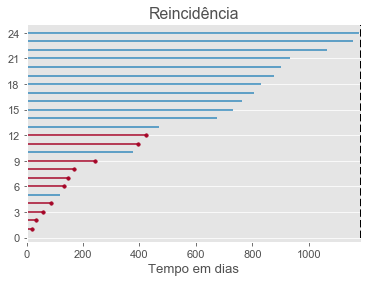

In [138]:
# Plotting only n individuals
df = df_compas.sample(n=25, random_state=0)

durations = df.duration.values
events = df.event.values

ax = plotting.plot_lifetimes(durations=durations, event_observed=events)
ax.set_xlim(0, 1186)
ax.vlines(1186, 0, 25, lw=2, linestyles='--')
ax.grid(axis='x')
ax.set_xlabel("Tempo em dias")
ax.set_title("Reincidência")
plt.plot()

In [139]:
# Table One
columns = ["sex", "score_text"]
groupby = ['race']
nonnormal = ["age"]

# create an instance of TableOne with the input arguments
grouped_table = TableOne(df_compas, columns=columns, groupby=groupby, 
                         nonnormal=nonnormal, missing=False,
                         dip_test=True, normal_test=True, tukey_test=True)

# view tableone
grouped_table

Grouped by race                                                                                 
                                 Overall African-American      Asian    Caucasian    Hispanic Native American       Other
n                                  10314             5147         51         3569         944              32         571
sex, n (%)        Female     2112 (20.5)       973 (18.9)    5 (9.8)   862 (24.2)  158 (16.7)        7 (21.9)  107 (18.7)
                  Male       8202 (79.5)      4174 (81.1)  46 (90.2)  2707 (75.8)  786 (83.3)       25 (78.1)  464 (81.3)
score_text, n (%) High       1952 (18.9)      1420 (27.6)    4 (7.8)   397 (11.1)    92 (9.7)        7 (21.9)    32 (5.6)
                  Low        5751 (55.8)      2184 (42.4)  38 (74.5)  2372 (66.5)  684 (72.5)       16 (50.0)  457 (80.0)
                  Medium     2611 (25.3)      1543 (30.0)   9 (17.6)   800 (22.4)  168 (17.8)        9 (28.1)   82 (14.4)

Text(0.5, 1.0, 'Distribuição de idade')

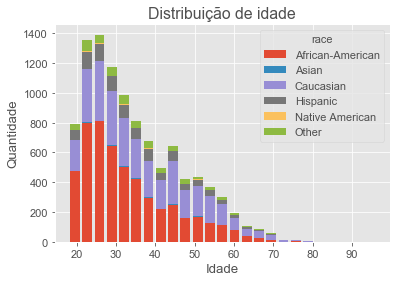

In [140]:
# Age distribution
ax = df_compas.pivot(columns='race').age.plot(kind = 'hist', stacked=True, bins=25, rwidth=0.8)
# ax.legend(labels=['outros', 'negros'])
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.title('Distribuição de idade')

Text(0.5, 1.0, 'Distribuição de prisões anteriores')

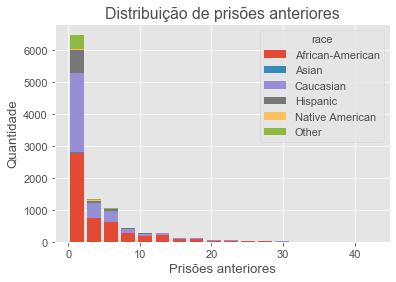

In [141]:
# prior arrest distribution
ax = df_compas.pivot(columns='race').priors_count.plot(kind = 'hist', stacked=True, bins=18, rwidth=0.8)
plt.xlabel('Prisões anteriores')
plt.ylabel('Quantidade')
plt.title('Distribuição de prisões anteriores')

Text(0.5, 1.0, 'Distribuição')

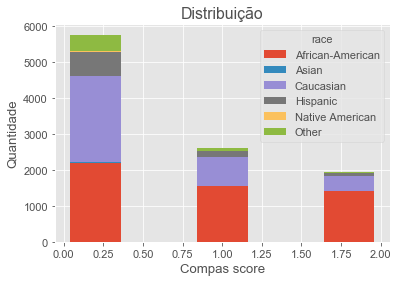

In [173]:
# Classificacao COMPAS de risco
ax = df_compas.pivot(columns='race').score_factor.plot(kind = 'hist', stacked=True, bins=5, rwidth=0.8)
plt.xlabel('Compas score')
plt.ylabel('Quantidade')
plt.title('Distribuição')

#### Kaplan Meier

In [174]:
T = df_compas["duration"]
E = df_compas["event"]

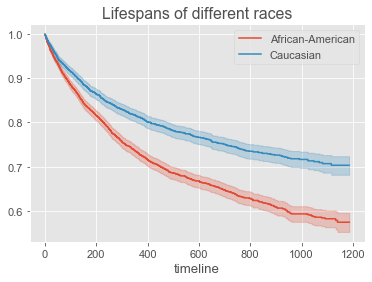

In [175]:
ax = plt.subplot(111)

dem_afam = (df_compas["race"] == "African-American")
dem_cau = (df_compas["race"] == "Caucasian")

kmf.fit(T[dem_afam], event_observed=E[dem_afam], label="African-American")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[dem_cau], event_observed=E[dem_cau], label="Caucasian")
kmf.plot_survival_function(ax=ax)

plt.title("Lifespans of different races");

#### Cox

In [160]:
df_compas["score_text"] = df_compas["score_text"].astype("category") 
df_compas["race"] = df_compas["race"].astype("category") 

In [156]:
cph = CoxPHFitter()
formula = "score_text"
cph.fit(df_compas, duration_col='duration', event_col='event', formula=formula)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [157]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24097.25
         time fit was run = 2021-09-20 02:24:22 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
score_text[T.Low]     -1.19       0.30       0.05            -1.29            -1.10                 0.28                 0.33
score_text[T.Medium]  -0.41       0.67       0.05            -0.50            -0.31                 0.60                 0.73

                          z      p   -log2(p)
covariate                                    
score_text[T.Low]    -25.26 <0.005     465.13
score_text[T.Medium]  -8.21 <0.005      51.97
---
Concordance = 0.63
Partial AIC = 48198.51
log-likelihood ratio test = 681.06 on 2 df
-log2(p) of ll-ratio test = 491.28

In [120]:
cph.check_assumptions(df_compas)

Proportional hazard assumption looks okay.


[]

In [121]:
formula="decile_score"
cph.fit(df_compas, duration_col='duration', event_col='event', formula=formula)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [122]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24035.89
         time fit was run = 2021-09-20 02:04:48 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
decile_score   0.19       1.21       0.01             0.17             0.20                 1.19                 1.22

                 z      p   -log2(p)
covariate                           
decile_score 28.69 <0.005     598.86
---
Concordance = 0.66
Partial AIC = 48073.77
log-likelihood ratio test = 803.80 on 1 df
-log2(p) of ll-ratio test = 584.97

In [163]:
formula = "race + score_text + race * score_text"
cph.fit(df_compas, duration_col='duration', event_col='event', formula=formula)

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>

In [164]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10314 total observations, 7555 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 10314
number of events observed = 2759
   partial log-likelihood = -24072.72
         time fit was run = 2021-09-20 02:27:32 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
race[T.Asian]                                  0.81       2.24       0.58            -0.33             1.94                 0.72                 6.96
race[T.Caucasian]                             -0.03       0.97       0.09            -0.21             0.15                 0.81                 1.16
race[T.Hispanic]                              -0.18       0.84       0.18            -0.53             0.17                 0.59                 1.19
race[T.Native American]                        0.13       1.14       0.58            -1.00             1.27                 0.37                 3.56
race[T.Other]                                  0.38       1.46       0.24            -0.09             0.85                 0.91                 2.33
score_text[T.Low]                             -1.02       0.36       0.06            -1.14            -0.89                 0.32                 0.41
score_text[T.Medium]                          -0.35       0.71       0.06            -0.47            -0.23                 0.63                 0.79
race[T.Asian]:score_text[T.Low]               -2.42       0.09       0.91            -4.22            -0.63                 0.01                 0.53
race[T.Caucasian]:score_text[T.Low]           -0.26       0.77       0.11            -0.49            -0.04                 0.62                 0.96
race[T.Hispanic]:score_text[T.Low]            -0.11       0.90       0.21            -0.51             0.29                 0.60                 1.34
race[T.Native American]:score_text[T.Low]    -12.80       0.00     297.20          -595.30           569.69                 0.00            2.60e+247
race[T.Other]:score_text[T.Low]               -0.72       0.49       0.27            -1.25            -0.20                 0.29                 0.82
race[T.Asian]:score_text[T.Medium]            -0.99       0.37       0.82            -2.59             0.62                 0.07                 1.86
race[T.Caucasian]:score_text[T.Medium]        -0.10       0.90       0.12            -0.34             0.13                 0.72                 1.14
race[T.Hispanic]:score_text[T.Medium]         -0.03       0.97       0.23            -0.48             0.43                 0.62                 1.54
race[T.Native American]:score_text[T.Medium]  -0.25       0.78       0.82            -1.86             1.35                 0.16                 3.87
race[T.Other]:score_text[T.Medium]            -0.73       0.48       0.32            -1.36            -0.11                 0.26                 0.90

                                                  z      p   -log2(p)
covariate                                                            
race[T.Asian]                                  1.39   0.16       2.61
race[T.Caucasian]                             -0.33   0.74       0.43
race[T.Hispanic]                              -1.01   0.31       1.67
race[T.Native American]                        0.23   0.82       0.29
race[T.Other]                                  1.57   0.12       3.11
score_text[T.Low]                            -16.41 <0.005     198.58
score_text[T.Medium]                          -5.78 <0.005      27.01
race[T.Asian]:score_text[T.Low]               -2.65   0.01       6.95
race[T.Caucasian]:score_text[T.Low]           -2.30   0.02       5.54
race[T.His

ICI =  0.010849694717334157
E50 =  0.014255962833886082


/Users/bruna/miniconda3/envs/fairness/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/bruna/miniconda3/envs/fairness/lib/python3.6/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a4469f1d0>,
 0.010849694717334157,
 0.014255962833886082)

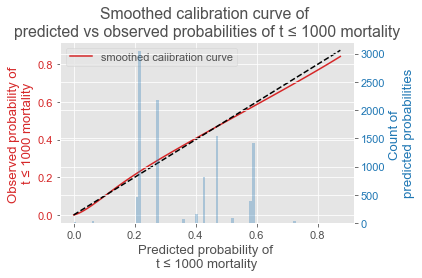

In [183]:
from lifelines.calibration import survival_probability_calibration

survival_probability_calibration(cph, df_compas, t0=1000)

In [201]:
censored_subjects_low = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'Low')]
censored_subjects_last_obs_low = censored_subjects_low['duration']

censored_subjects_med = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'Medium')]
censored_subjects_last_obs_med = censored_subjects_med['duration']

censored_subjects_hi = df_compas.loc[(~df_compas['event'].astype(bool)) & (df_compas['score_text'] == 'High')]
censored_subjects_last_obs_hi = censored_subjects_hi['duration']

# predict new survival function
pred_low = cph.predict_survival_function(censored_subjects_low, conditional_after=censored_subjects_last_obs_low)
pred_med = cph.predict_survival_function(censored_subjects_med, conditional_after=censored_subjects_last_obs_med)
pred_hi = cph.predict_survival_function(censored_subjects_hi, conditional_after=censored_subjects_last_obs_hi)

In [202]:
def survival_curve_median_calc(surv1, surv2):
    # Median and standard deviation
    df_surv_median1 = surv1.median(axis=1)
    df_surv_std1 = surv1.std(axis=1)
    df_surv_median2 = surv2.median(axis=1)
    df_surv_std2 = surv2.std(axis=1)

    return df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2


def survival_curve_plot(surv1, surv2, label1, label2, group_name):
    df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2 = survival_curve_median_calc(surv1, surv2)

    # 95% Confidence interval
    ci1_left = surv1.quantile(0.025, axis=1)
    ci1_right = surv1.quantile(0.975, axis=1)
    ci2_left = surv2.quantile(0.025, axis=1)
    ci2_right = surv2.quantile(0.975, axis=1)

    # Plot curves
    ax = df_surv_median1.plot(label=label1, color='turquoise', linestyle='--')
    ax.fill_between(df_surv_median1.index, ci1_left, ci1_right, alpha=0.2, facecolor='turquoise')

    ax.plot(df_surv_median2, label=label2, color='slateblue', linestyle='-.')
    ax.fill_between(df_surv_median2.index, ci2_left, ci2_right, alpha=0.2, facecolor='slateblue')

    plt.legend(loc="upper right")
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')

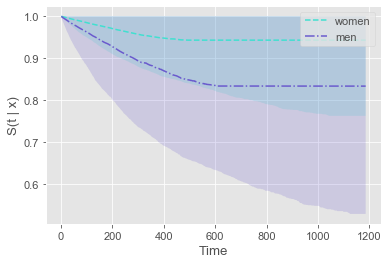

In [204]:
survival_curve_plot(pred_low, pred_med, "women", "men", "women-men")

In [186]:
# cph.plot_partial_effects_on_outcome('race', values=np.arange(0, 2, 1))